## Setup

In [ ]:
!pip install tweetopic
!pip install pandas
!pip install tweetopic[viz]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Loading and preprocessing of data

In [ ]:
# creating functions to use at a later point

def sent_to_words(sentences):
    
    '''Takes in a list of strings, 
    splits each string into words and outputs a list containing one list for each original string.'''

    for sentence in sentences:
        #deacc=True # removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords_func(texts, stopword_list):
  
  '''Takes in a list of lists where each element is a word in a sentence, 
  removes stopwords and outputs in the same format as original'''
  
  return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopword_list] for doc in texts]

In [ ]:
import pandas as pd
import re
from gensim.utils import simple_preprocess
import gensim

# read file with stopwords stopwords
with open('/content/drive/MyDrive/nlp_model/stopord.txt') as f: # https://gist.github.com/berteltorp/0cf8a0c7afea7f25ed754f24cfc2467b#file-stopord-txt
    lines = f.readlines()

# create list from stopwords file
for i, val in enumerate(lines):
  new_line = val.replace("\n", "")
  lines[i] = new_line

# adding additional words to stopword list
for i in ["link", "dkpol", "rt", "pa", "sa", "amp", "fa", "nar", "ma"]: # add additional weird words that have to be removed here
  lines.append(i)

# fixing GSDMM handling of å
lines_v2 = [line.replace("å", "a") for line in lines] # at a later point the GSDMM function has problems with å that causes a large amount of the stopwords to stay in the data

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Load data
df_all = pd.read_csv("/content/drive/MyDrive/nlp_model/tweets_data_temp.csv")

# Cleaning up dataset
df_all.text = df_all.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1) # removes links
df_all.text = df_all.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1) # removing twitter handles
df_all.text = df_all.apply(lambda row: " ".join(re.sub("[^a-zA-ZÆæØøÅå]+", " ", row.text).split()), 1) # removing symbols

# withdrawing tweet data from dataframe and split each sentence into words
tweets = df_all.text.values.tolist()
data_words = list(sent_to_words(tweets))

# remove stop words
data_words = remove_stopwords_func(data_words, stopword_list = lines_v2)

tweets = [(" ").join(i) for i in data_words]

## Optimising for coherence

Generating variables used for calculation of topic coherence

In [ ]:
import gensim.corpora as corpora
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

Creating for-loop that creates an instance of tweetopic with 2 to 100 mixture components with 2 components increments

In [ ]:
from pprint import pprint
from tweetopic import TopicPipeline, DMM
from sklearn.feature_extraction.text import CountVectorizer

num_components_ls = []
coherence_gsdmm_model_ls = []

range_coherence = list(range(2,100,1))

for i in range_coherence:
  
  # number of mixture components
  num_components = i

  # Creating a vectorizer for extracting document-term matrix from the
  # text corpus.
  vectorizer = CountVectorizer(min_df=15, max_df=0.1)

  # Creating a Dirichlet Multinomial Mixture Model with i components
  dmm = DMM(n_components=i, n_iterations=100, alpha=0.1, beta=0.1)

  # Creating topic pipeline
  pipeline = TopicPipeline(vectorizer, dmm)

  pipeline.fit_transform(tweets)

  # get topic representations
  topics = pipeline.top_words(top_n=10)

  words = [list(topics[i].keys()) for i in range(len(topics)) if len(topics[i]) != 0]
  
  # Compute Coherence Score
  cm = CoherenceModel(topics=words, corpus=corpus, dictionary=id2word, texts = texts, coherence='c_v')
  coherence = cm.get_coherence()  # get coherence value

  num_components_ls.append(num_components)
  coherence_gsdmm_model_ls.append(coherence)


df = pd.DataFrame()
df["num_components"] = num_components_ls
df["coherence"] = coherence_gsdmm_model_ls

Visualising the coherence scores

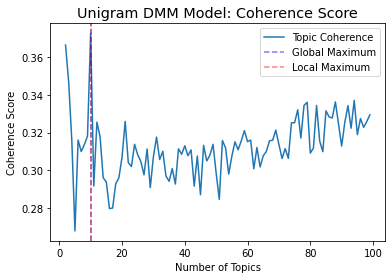

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.lineplot(data = df, x = 'num_topics', y = 'coherence', label = 'Topic Coherence')
plt.axvline(df["num_topics"][df['coherence'].idxmax()], linestyle = "--", color = "b", alpha = 0.5, label = "Global Maximum")
plt.axvline(df["num_topics"][df['coherence'][(df["num_topics"] > 0) & (df["num_topics"] < 30)].idxmax()], linestyle = "--", color = "r", alpha = 0.5, label = "Local Maximum")
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
plt.title(label = "Unigram DMM Model: Coherence Score", fontsize = "x-large", fontweight = "roman")
plt.legend()
#ax.figure.savefig("/content/drive/MyDrive/bachelor_model_data/output.eps", format='eps')
ax.figure.savefig("/content/drive/MyDrive/bachelor_model_data/output_dmm_unigram.png", dpi = 1200)

In [ ]:
# printing number of mixture components for highest coherence score
print(df["num_components"][df['coherence'].idxmax()])

Producing final instance of model for comparison

In [ ]:
num_components = df["num_components"][df['coherence'].idxmax()]

# Creating a vectorizer for extracting document-term matrix from the
# text corpus.
vectorizer = CountVectorizer(min_df=15, max_df=0.1)

# Creating a Dirichlet Multinomial Mixture Model with 30 components
dmm = DMM(n_components=num_components, n_iterations=100, alpha=0.1, beta=0.1)

# Creating topic pipeline
pipeline = TopicPipeline(vectorizer, dmm)

pipeline.fit_transform(tweets)

pipeline.top_words(top_n=10)

In [ ]:
# get topic representations
topics = pipeline.top_words(top_n=10)

words = [list(topics[i].keys()) for i in range(len(topics))]

# Create Topics
topics = [' & '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
user & eu & eudk & brexit & dk & arets & dkbiz & gode & danmarks & dkmedier

------ Topic 1 ------
faktisk & siger & ret & tror & hele & første & fald & desværre & ting & sldk

------ Topic 2 ------
dkmedier & danmark & dag & ar & tror & hele & gang & ret & ga & gar

------ Topic 3 ------
df & politik & stemme & regeringen & dansk & partier & bla & stemmer & valg & gar

------ Topic 4 ------
kr & dag & ar & mio & nye & stort & set & sidste & politidk & blevet

------ Topic 5 ------
sldk & fc & brøndby & søndag & kamp & ude & kampen & aab & mal & fans

------ Topic 6 ------
artikel & plus & højere & handler & betaler & skat & enig & folk & hurtigt & grad

------ Topic 7 ------
the & of & is & and & pldk & it & vej & spændende & del & lande

------ Topic 8 ------
ar & bedre & unge & penge & kæmpe & seneste & børn & giver & nye & give

------ Topic 9 ------
tv & sldk & pldk & direkte & kampe & fodbold & dag & live & events & la

